In [43]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [44]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 100

keras version  2.11.0


In [45]:
dfMet = pd.read_csv("metadata.csv")
dfSig = pd.read_csv("signals.csv")

In [46]:
dfMet.head(5)

,user_snippet,x-axis__sum_values,x-axis__median,x-axis__mean,x-axis__length,x-axis__standard_deviation,x-axis__variance,x-axis__root_mean_square,x-axis__maximum,x-axis__absolute_maximum,...,z-axis__median,z-axis__mean,z-axis__length,z-axis__standard_deviation,z-axis__variance,z-axis__root_mean_square,z-axis__maximum,z-axis__absolute_maximum,z-axis__minimum,activity
0,1008_0,-208.0,-1.8,-2.1,100.0,4.7,22.1,5.1,7.5,16.0,...,1.8,2.4,100.0,4.0,16.0,4.7,14.3,14.3,-4.4,Upstairs
1,1008_1,29.0,0.5,0.3,100.0,2.7,7.0,2.7,5.9,8.8,...,2.3,2.6,100.0,3.1,9.9,4.1,14.6,14.6,-5.8,Upstairs
2,1008_2,-160.3,-1.0,-1.6,100.0,5.7,32.6,5.9,9.8,17.6,...,-0.1,0.2,100.0,4.6,20.9,4.6,9.5,9.5,-7.3,Walking
3,1008_3,-138.3,-1.9,-1.4,100.0,4.1,16.5,4.3,6.5,12.7,...,1.5,2.6,100.0,5.8,33.3,6.3,14.6,14.6,-6.7,Jogging
4,1008_4,-184.3,-2.0,-1.8,100.0,3.8,14.6,4.2,7.7,8.7,...,1.6,2.2,100.0,5.8,33.8,6.2,18.2,18.2,-9.4,Jogging


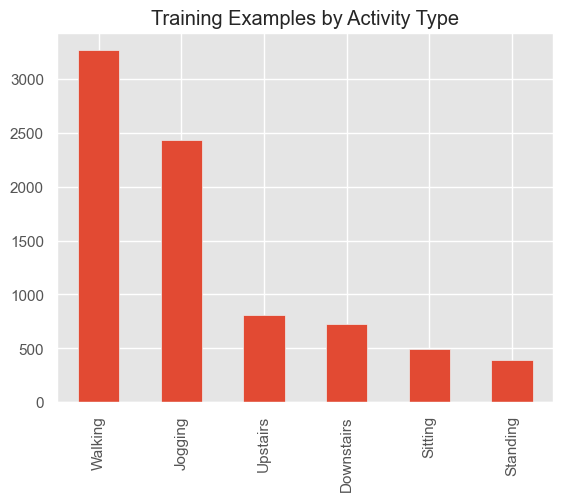

In [47]:
# Show how many activity exists for each of the six activities
dfMet['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()


In [48]:
# merge signals and metadata dataframes on user_id
merged = pd.merge(dfSig, dfMet[['user_snippet', 'activity']], on='user_snippet')

# add a new column 'activity_type_by_user' based on 'activity_type'

merged.head(400)
merged.to_csv('signalsMerged.csv', index=False)


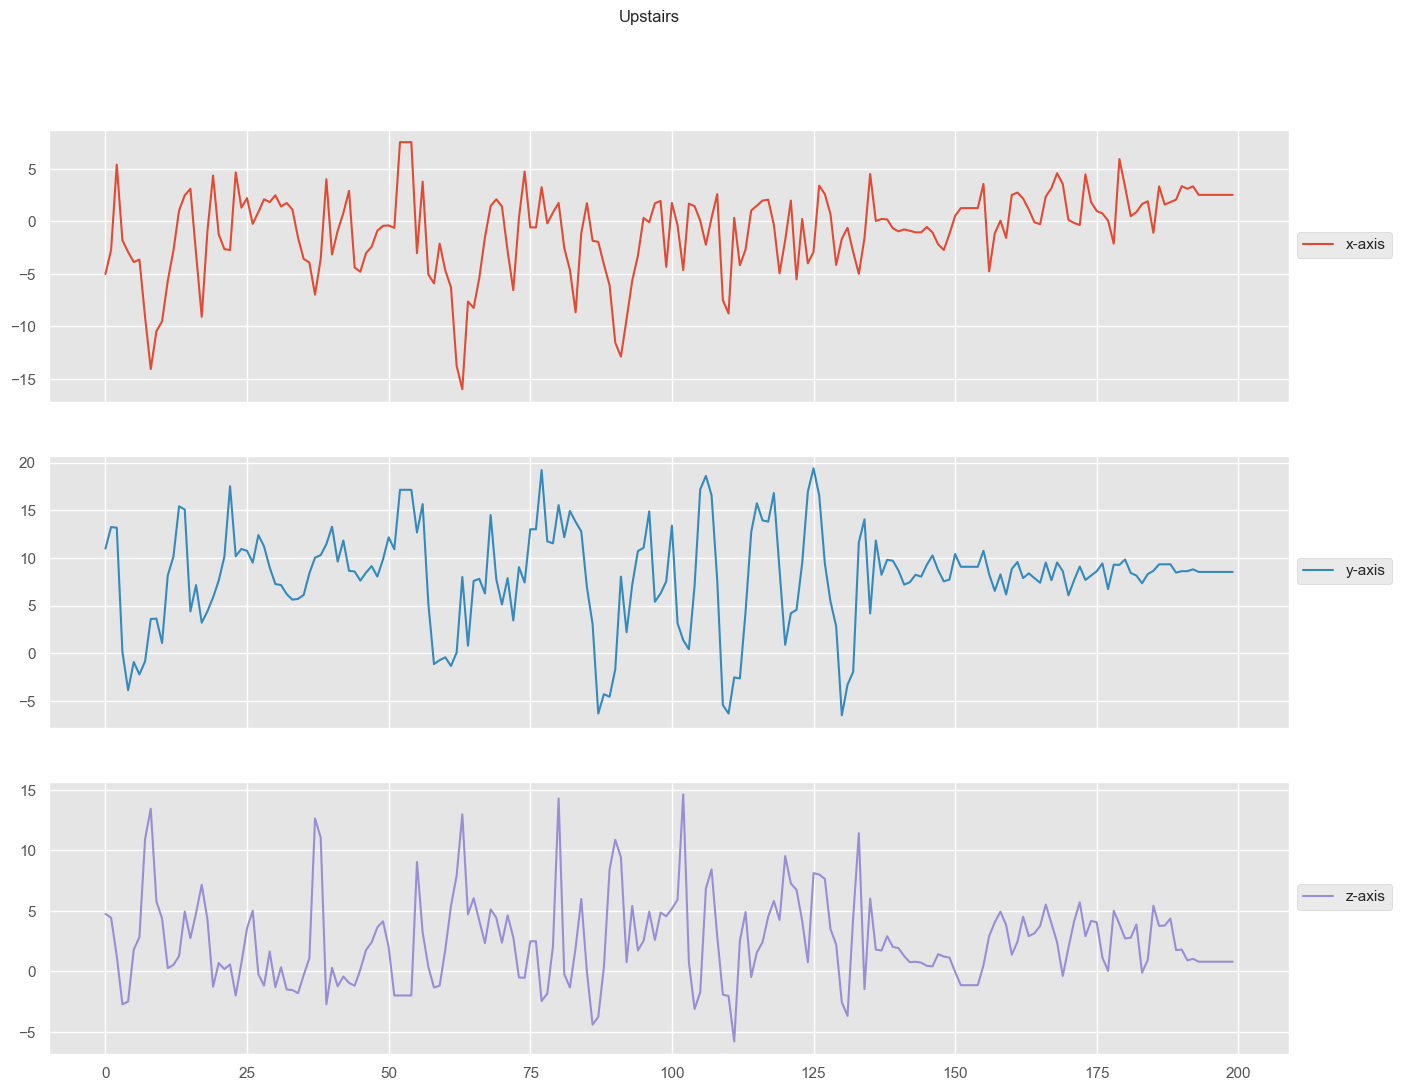

In [49]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plot_activity("Upstairs", merged)

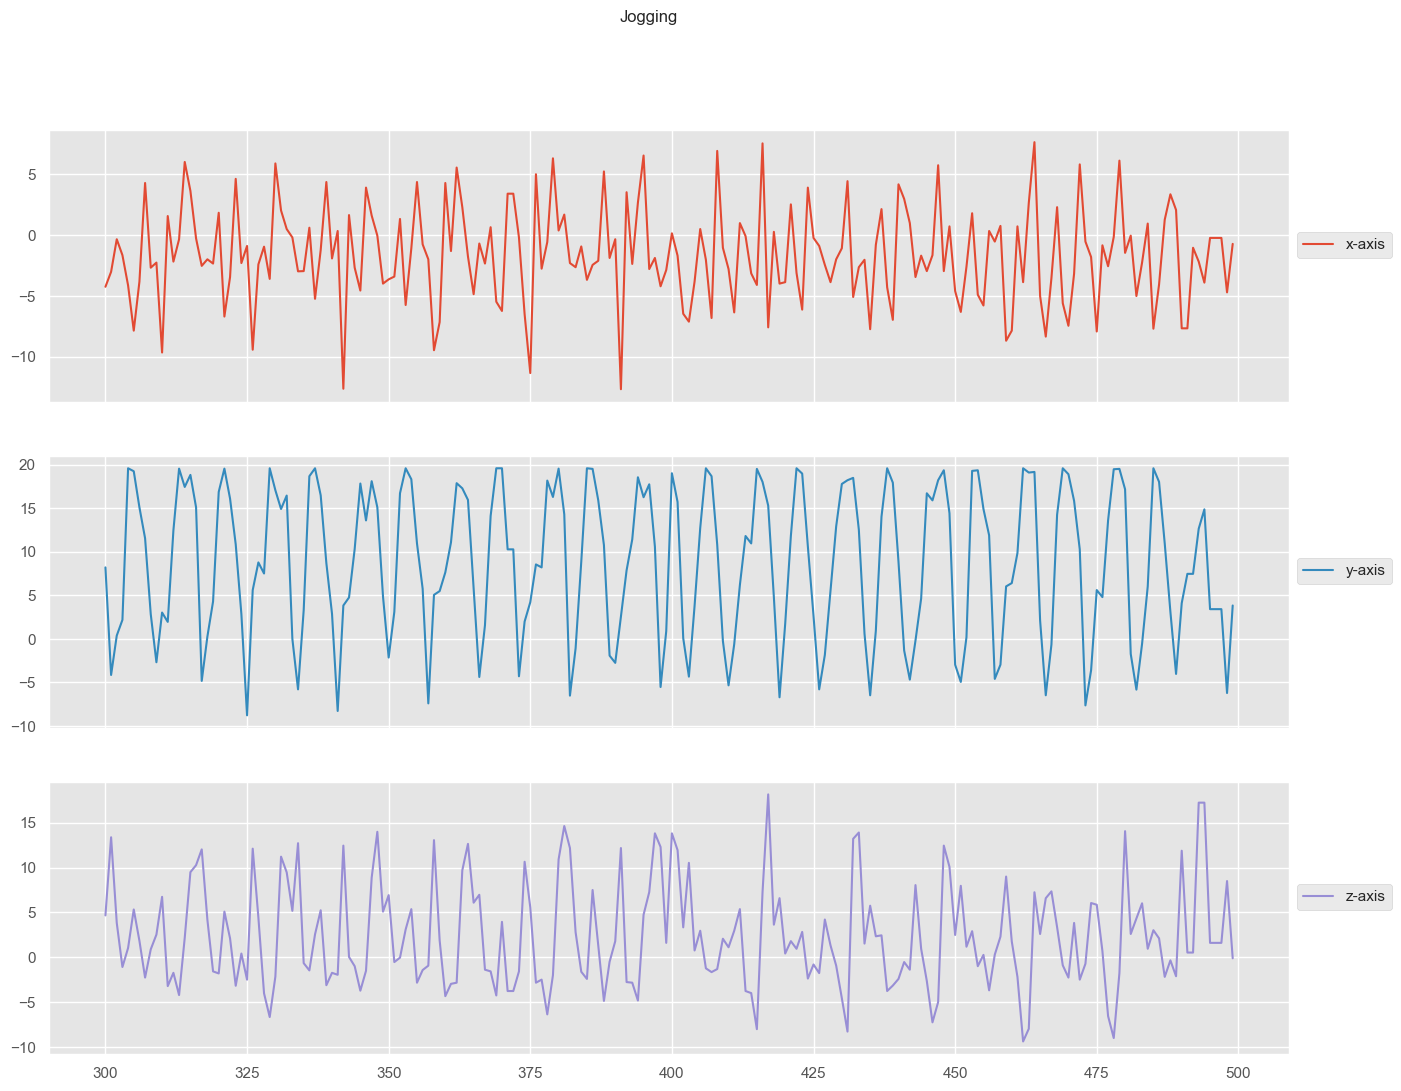

In [50]:
plot_activity("Jogging", merged)

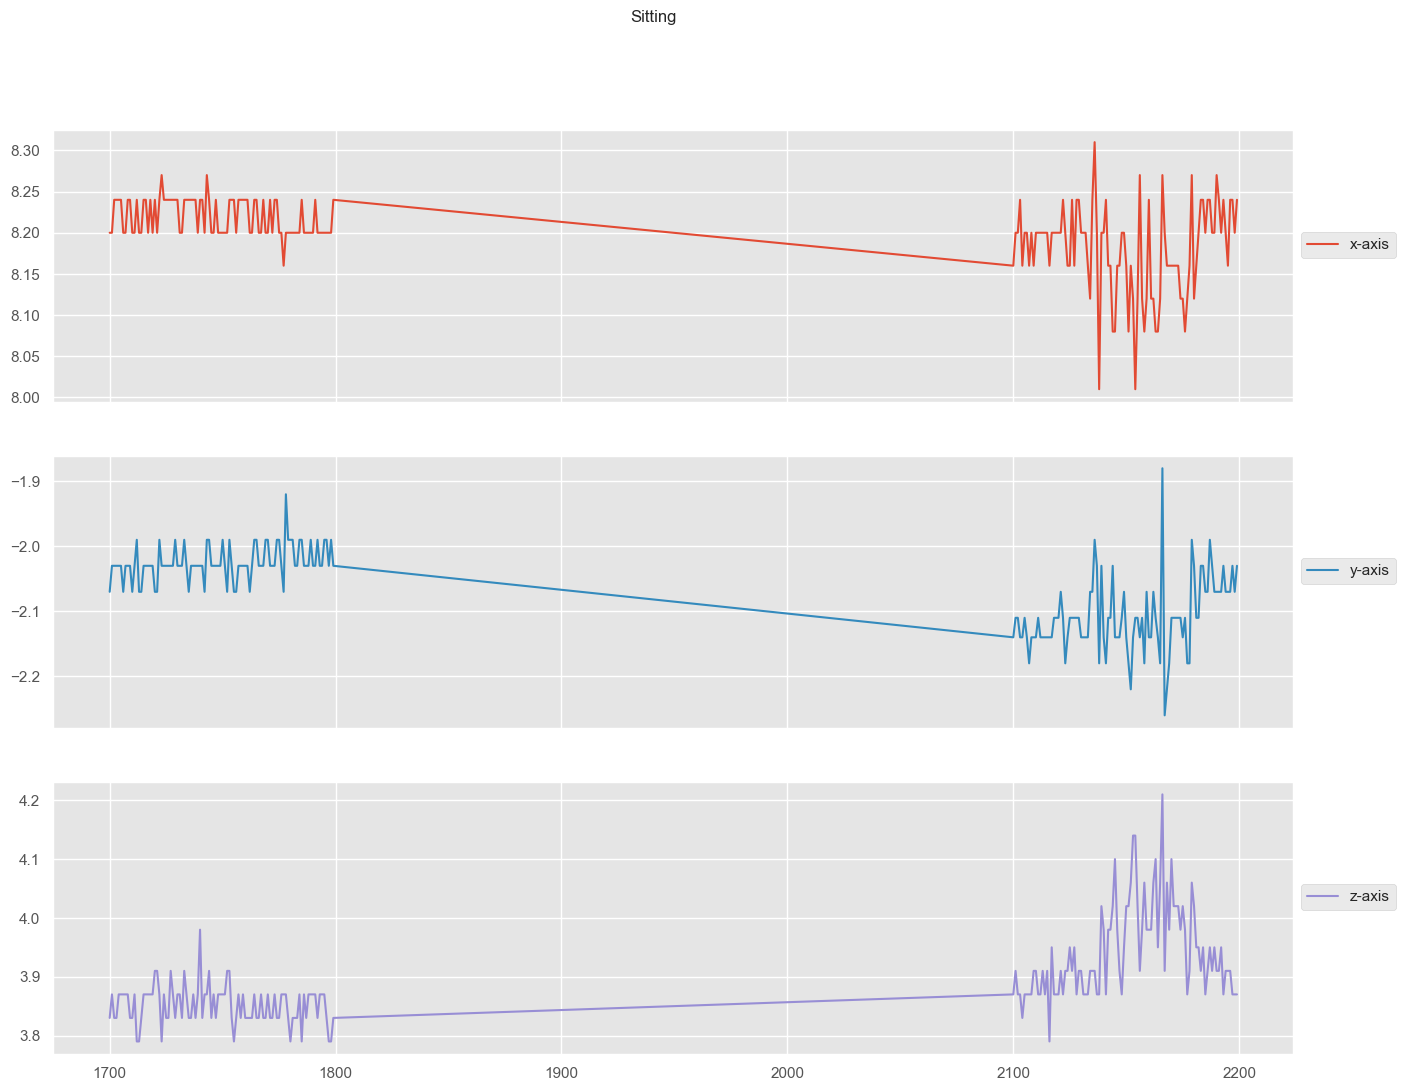

In [51]:

plot_activity("Sitting", merged)

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

user_snippets = merged['user_snippet'].unique()
train_user_snippets, test_user_snippets = train_test_split(user_snippets, train_size=0.8, random_state=42)

# Split the dataset based on the user snippets
train_df = merged[merged['user_snippet'].isin(train_user_snippets)]
test_df = merged[merged['user_snippet'].isin(test_user_snippets)]
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape,)

Training set shape: (649289, 6)
Testing set shape: (162348, 6)


In [53]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
merged[LABEL] = le.fit_transform(merged['activity'].values.ravel())
# Set input & output dimensions
# num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
merged['x-axis'] = merged['x-axis'] / merged['x-axis'].max()
merged['y-axis'] = merged['y-axis'] / merged['y-axis'].max()
merged['z-axis'] = merged['z-axis'] / merged['z-axis'].max()
# Round numbers
merged= merged.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(merged,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


/var/folders/22/h8l8_ytn26795g34vc91mq5h0000gp/T/ipykernel_98441/1105249254.py:33: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


In [54]:

print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (8116, 100, 3)
8116 training samples
y_train shape:  (8116,)


In [55]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [56]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (8116, 300)
input_shape: 300


In [57]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [58]:

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (8116, 6)


In [59]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100, 3)            0         
                                                                 
 dense_4 (Dense)             (None, 100, 100)          400       
                                                                 
 dense_5 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_6 (Dense)             (None, 100, 100)          10100     
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_7 (Dense)             (None, 6)                 60006     
                                                                 
Total params: 80,606
Trainable params: 80,606
Non-trai

In [60]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
17/17 [==============================] - 15s 369ms/step - loss: 1.4291 - accuracy: 0.4643 - val_loss: 1.1644 - val_accuracy: 0.5942
Epoch 2/50
17/17 [==============================] - 5s 291ms/step - loss: 1.0887 - accuracy: 0.6223 - val_loss: 0.8849 - val_accuracy: 0.7026
Epoch 3/50
17/17 [==============================] - 4s 256ms/step - loss: 0.8264 - accuracy: 0.6996 - val_loss: 0.7755 - val_accuracy: 0.7284
Epoch 4/50
17/17 [==============================] - 5s 297ms/step - loss: 0.7150 - accuracy: 0.7492 - val_loss: 0.7857 - val_accuracy: 0.7223
Epoch 5/50
17/17 [==============================] - 5s 281ms/step - loss: 0.6554 - accuracy: 0.7611 - val_loss: 0.7837 - val_accuracy: 0.7291
Epoch 6/50
17/17 [==============================] - 5s 321ms/step - loss: 0.6179 - accuracy: 0.7770 - val_loss: 0.7594 - val_accuracy: 0.7426
Epoch 7/50
17/17 [==============================] - 4s 242ms/step - loss: 0.5858 - accuracy: 0.7876 - val_loss: 0.7456 - val_accuracy: 0.7426
Epoch

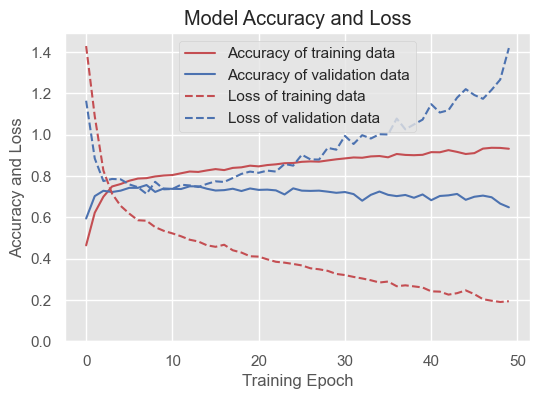

254/254 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

         0.0       0.63      0.82      0.71       746
         1.0       0.92      0.98      0.95      2466
         2.0       1.00      0.96      0.98       498
         3.0       0.98      0.95      0.96       386
         4.0       0.61      0.80      0.69       810
         5.0       0.94      0.76      0.84      3210

    accuracy                           0.86      8116
   macro avg       0.85      0.88      0.86      8116
weighted avg       0.88      0.86      0.86      8116



In [61]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [62]:
test_df = pd.read_csv('signals_test.csv')

In [63]:
def create_segments_and_labels2(df, time_steps, step):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        segments.append([xs, ys, zs])
        

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    

    return reshaped_segments

In [64]:
pd.options.mode.chained_assignment = None  # default='warn'
test_df['x-axis'] = test_df['x-axis'] / test_df['x-axis'].max()
test_df['y-axis'] = test_df['y-axis'] / test_df['y-axis'].max()
test_df['z-axis'] = test_df['z-axis'] / test_df['z-axis'].max()
# Round numbers
test_df= test_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
x_test = create_segments_and_labels2(test_df,TIME_PERIODS,STEP_DISTANCE)
num_time_periods, num_sensors = x_test.shape[1], x_test.shape[2]
input_shape = (num_time_periods*num_sensors)
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_test.shape)

x_train shape: (2616, 300)


In [65]:
x_test = x_test.astype('float32')

In [66]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the train predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)



82/82 [==============================] - 1s 9ms/step


In [72]:
prediction = le.inverse_transform(max_y_pred_test)
prediction =np.append(prediction,['Sitting','Sitting','Sitting','Sitting','Sitting'])

In [74]:
submit = pd.read_csv('predictions_sample.csv')
submit['prediction'] = prediction
submit.to_csv('submit.csv',index=False)